In [1]:
from qiskit import *
# Qiskit module
from qiskit import QuantumCircuit
import qiskit.circuit.library as circuit_library
import qiskit.quantum_info as qi
import qiskit.ignis.mitigation as mit
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise

import itertools

# Qiskit tools for running and monitoring jobs
from qiskit import execute
from qiskit.tools.monitor import job_monitor

from qiskit.tools.visualization import *
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.special import erf
# Other imports
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
import mitiq

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

from qiskit.circuit.gate import Gate

# Fake backend
#from qiskit.test.mock import FakeAthens

from scipy import integrate

In [2]:
#Define the functions used to build the Trotter circuit.
def h_Z(qc,h,dt):
    for i in range(5):
        if i==0 or i==4:
            qc.rz(h*dt,i)
        else:
            qc.rz(2*h*dt,i)
        
def X_Rabi(qc,Omega,dt): # Rabi coupling
    
    for i in range(5):
        
        qc.rx(2*Omega*dt,i)
        
def ZZ(qc,V,dt): # nearest neighbor coupling
    
    qc.cx(0,1)
    
    qc.rz(-2*V*dt,1)
    
    qc.cx(0,1)
    
    qc.cx(2,3)
    
    qc.rz(-2*V*dt,3)
    
    qc.cx(2,3)
    
    qc.cx(1,2)
    
    qc.rz(-2*V*dt,2)
    
    qc.cx(1,2)
    
    qc.cx(3,4)
    
    qc.rz(-2*V*dt,4)
    
    qc.cx(3,4)

def Trotter_circuit_5_site(h,Omega,V,T,n):
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(5)
        
        ### Initial state setting
        
        Trotter_circuit.x(1)
        
        Trotter_circuit.x(3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            X_Rabi(Trotter_circuit,Omega,dt) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt) # Z field 
            
            ZZ(Trotter_circuit,V,dt) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        Trotter_circuit.measure_all()
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

In [3]:
#Parameters used for the Trotter cirucit
Omega = 0.2*2

h = 2*2

V = 1*2

T = 10 # Total time

TT=T

#NEED TO CHECK IF THIS IS ALLOWED
delta_t = .5

#CHECK THIS AS WELL
n = int(np.rint(T/delta_t))

NN=n

Trotter_circuit = Trotter_circuit_5_site(h,Omega,V,T,n)

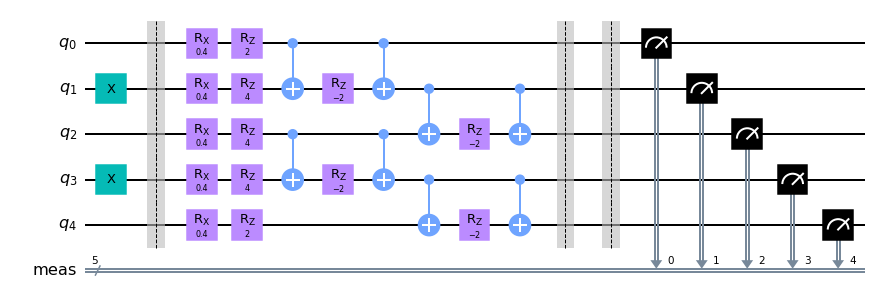

In [4]:
Trotter_circuit[1].draw(output='mpl')

In [5]:
#This cell sets up everything we need so the readout error mitigation will work.
from qiskit.test.mock import FakeBogota
from qiskit.test.mock import FakeVigo

backend = FakeVigo()
# backend = FakeBogota()

#This needs to be 5, since we have 5 qubits in our circuit.
qr = QuantumRegister(5)

noise_model = NoiseModel.from_backend(backend)

qubit_list = [0,1,2,3,4]

meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

qasm_sim = Aer.get_backend('qasm_simulator')

t_qc = transpile(meas_calibs, backend) #Aer.get_backend('qasm_simulator'))
qobj = assemble(t_qc, shots=10000)

#note that the noise model isn't used until here. All the code in this cell above this comment is
# simply doing calibration of the circuit.
cal_results = qasm_sim.run(qobj, noise_model=noise_model, shots=10000).result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

meas_filter = meas_fitter.filter

In [6]:
def post_selection(bit_str):
    """This function takes in a bitstring, and will return True iff 
    there is a 1 next to another 1 in the given bitstring.
    This does NOT consider a bitstring with 1s on either end as next to one another,
    i.e. given a string of the form '10...01', this function should return False"""
    new_str = '0' + bit_str[0:len(bit_str)]
    for i in range(0,len(bit_str)+1):
        if (new_str[i] == '1') & (new_str[i] == new_str[i-1]):
            return True
    return False

def post_selected_expval(counts, qubit):
    """This function takes in the counts from a circuit execution, as well as a qubit index, 
    and outputs <Z> for that qubit after post-selection"""
    copy_counts = counts.copy()
    
    total = []

    for x in counts.keys():
        if post_selection(x):
            copy_counts.pop(x)

    for x in copy_counts:
        total.append(copy_counts[x])

    total = sum(total)

    one_counts = 0

    for x in copy_counts.keys():
        if x[qubit] == '1':
            one_counts += copy_counts[x]

    prob = one_counts / total

    expval = 2*prob - 1
    
    return expval

In [7]:
def Z(bitstring, bit):
    """Function that takes in a bitstring, as well as a bit, and returns -1 if the specified bit in the
    bitstring is a 1. Returns 1 otherwise."""
    if bitstring[bit] == '1':
        return -1
    else:
        return 1

def ZZ_measurement(bitstring, bit1, bit2):
    """Apply the Z function to two bits, and find their product"""
    return Z(bitstring, bit1) * Z(bitstring, bit2)

def ZZ_meas_expval(counts, bit1, bit2):
    """This function takes in the counts from after a cirucit execution, then post-selects them.
    After this, <Z_i Z_{i+1}> is calculated and output."""
    copy_counts = counts.copy()
    total = []

    for x in counts.keys():
        if post_selection(x):
            copy_counts.pop(x)
    
    for x in copy_counts:
        total.append(copy_counts[x])
    
    total = sum(total)

    one_counts = 0

    for x in copy_counts.keys():
        if x[bit1] == '1':
            one_counts += copy_counts[x]

    prob = one_counts / total
    
    expval_list = []
    
    for x in copy_counts.keys():
        expval_list.append(ZZ_measurement(x,bit1,bit2) * copy_counts[x]/total)
    
    return sum(expval_list)

In [8]:
# from qiskit.test.mock import FakeVigo

#Use a backend with an error model
# backend = FakeBogota()

ideal_backend = Aer.get_backend('qasm_simulator')

def random_SwapTestExecutor(circuits, backend, shots, post_sel_func, qubit):
    scale_factors = [1.0, 2.0, 3.0]
    folded_circuits = []
    for circuit in circuits:
        folded_circuits.append([mitiq.zne.scaling.fold_gates_at_random(circuit, scale) for scale in scale_factors])
    folded_circuits = list(itertools.chain(*folded_circuits))

    job = qiskit.execute(
        experiments=folded_circuits,
        backend=backend,
        optimization_level=0,
        shots=shots
    )

    results = job.result()
    mit_results = meas_filter.apply(results)

    expectation_values = []

    for t in range(len(folded_circuits)):
        expectation_values.append(post_selected_expval(mit_results.get_counts(t),qubit))

    zero_noise_values = []
    if isinstance(backend, qiskit.providers.aer.backends.qasm_simulator.QasmSimulator): # exact_sim
        for i in range(len(circuits)):
            zero_noise_values.append(np.mean(expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))
    else: #device_sim
        fac = mitiq.zne.inference.LinearFactory(scale_factors)
        for i in range(len(circuits)):
            zero_noise_values.append(fac.extrapolate(scale_factors, 
            expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))

    return zero_noise_values

def global_SwapTestExecutor(circuits, backend, shots, post_sel_func, qubit):
    scale_factors = [1.0, 2.0, 3.0]
    folded_circuits = []
    for circuit in circuits:
        folded_circuits.append([mitiq.zne.scaling.fold_global(circuit, scale) for scale in scale_factors])
    folded_circuits = list(itertools.chain(*folded_circuits))

    job = qiskit.execute(
        experiments=folded_circuits,
        backend=backend,
        optimization_level=0,
        shots=shots
    )

    results = job.result()
    mit_results = meas_filter.apply(results)

    expectation_values = []

    for t in range(len(folded_circuits)):
        expectation_values.append(post_selected_expval(mit_results.get_counts(t),qubit))

    zero_noise_values = []
    if isinstance(backend, qiskit.providers.aer.backends.qasm_simulator.QasmSimulator): # exact_sim
        for i in range(len(circuits)):
            zero_noise_values.append(np.mean(expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))
    else: #device_sim
        fac = mitiq.zne.inference.LinearFactory(scale_factors)
        for i in range(len(circuits)):
            zero_noise_values.append(fac.extrapolate(scale_factors, 
            expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))

    return zero_noise_values

In [9]:
global_SwapTestExecutor(Trotter_circuit, ideal_backend, 8192, post_selection, 0)

[-0.9999999998963389,
 -0.9999999999996275,
 -0.9999999999971982,
 -0.9814484673863612,
 -0.8366386068108614,
 -0.660663530398796,
 -0.3840740629576656,
 -0.022442330210173538,
 0.3189984431855888,
 0.6479381443772775,
 0.8902387027740222,
 0.9651377296153111,
 0.9535497993703826,
 0.7642503550577059,
 0.4597544806094682,
 0.07984810576046415,
 -0.2933690978418614,
 -0.6142876742229733,
 -0.8588900208013351,
 -0.9689739225535362]

In [10]:
# real_device_dict = {}
ideal_dict = {}
rand_dict = {}
global_dict = {}


for qubit in range(5):
#     real_device_dict.update({qubit: SwapTestExecutor(Trotter_circuit, backend, 8192, post_selection, qubit)})
    ideal_dict.update({qubit: random_SwapTestExecutor(Trotter_circuit, ideal_backend, 8192, post_selection, qubit)})
    rand_dict.update({qubit: random_SwapTestExecutor(Trotter_circuit, backend, 8192, post_selection, qubit)})
    global_dict.update({qubit: global_SwapTestExecutor(Trotter_circuit, backend, 8192, post_selection, qubit)})

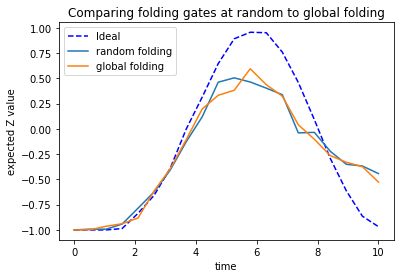

In [11]:
t=np.linspace(0,TT,NN)

fig,ax = plt.subplots()
# ax.plot(t, real_device_dict[0], label='Qubit 0', color = 'blue')
ax.plot(t, ideal_dict[0], linestyle = 'dashed', color = 'blue', label = 'Ideal')
# ax.plot(t, real_device_dict[1], label='Qubit 1', color = 'orange')
# ax.plot(t, ideal_dict[1], linestyle = 'dashed', color = 'orange')
# ax.plot(t, real_device_dict[2], label='Qubit 2', color = 'red')
# ax.plot(t, ideal_dict[2], linestyle = 'dashed', color = 'red')
# ax.plot(t, real_device_dict[3], label='Qubit 3', color = 'green')
# ax.plot(t, ideal_dict[3], linestyle = 'dashed', color = 'green')
# ax.plot(t, real_device_dict[4], label='Qubit 4', color = 'black')
# ax.plot(t, ideal_dict[4], linestyle = 'dashed', color = 'black')
ax.plot(t, rand_dict[0], label = 'random folding')
ax.plot(t, global_dict[0], label = 'global folding')
ax.set_xlabel('time')
ax.set_ylabel('expected Z value')
ax.set_title("Comparing folding gates at random to global folding")
ax.legend()

In [12]:
rand_deviation = []
global_deviation = []

for item in range(len(rand_dict[0])):
    rand_deviation.append(np.abs(rand_dict[0][item] - ideal_dict[0][item]))
    global_deviation.append(np.abs(global_dict[0][item] - ideal_dict[0][item]))

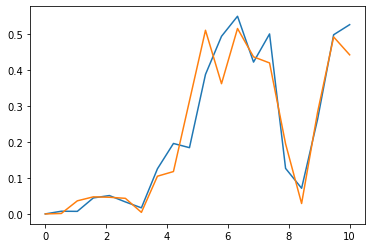

In [13]:
fig,ax = plt.subplots()
ax.plot(t, rand_deviation)
ax.plot(t, global_deviation)

In [64]:
temp1 = []
temp2 = []
temp3 = []
for sample in range(25):
    temp1.append(random_SwapTestExecutor(Trotter_circuit, ideal_backend, 8192, post_selection, 0))
    temp2.append(random_SwapTestExecutor(Trotter_circuit, backend, 8192, post_selection, 0))
    temp3.append(global_SwapTestExecutor(Trotter_circuit, backend, 8192, post_selection, 0))

In [65]:
ideal_averaged_list = []
rand_fold_averaged_list = []
global_fold_averaged_list = []

for t in range(len(temp1[0])):
    temp_list1 = []
    temp_list2 = []
    temp_list3 = []
    for sample1,sample2,sample3 in zip(temp1,temp2,temp3):
        temp_list1.append(sample1[t])
        temp_list2.append(sample2[t])
        temp_list3.append(sample3[t])
    ideal_averaged_list.append(np.average(temp_list1))
    rand_fold_averaged_list.append(np.average(temp_list2))
    global_fold_averaged_list.append(np.average(temp_list3))
    
# ideal_averaged_list
# rand_fold_averaged_list
# global_fold_averaged_list

deviation1 = []
deviation2 = []

for x in range(20):
    deviation1.append(ideal_averaged_list[x] - rand_fold_averaged_list[x])
    deviation2.append(ideal_averaged_list[x] - global_fold_averaged_list[x])

deviation1

[2.50893750219916e-11,
 0.0032633513021582683,
 -0.011421461303947167,
 -0.011608463148723991,
 -0.022057180512440655,
 -0.009746186389445355,
 0.012102116681758313,
 0.09950881329812533,
 0.16136472177190236,
 0.3086717212652945,
 0.408839510144952,
 0.46190097372448136,
 0.5595576877537294,
 0.476741578636039,
 0.37782031685997,
 0.14781003142105392,
 -0.07441117516861961,
 -0.25777835654630854,
 -0.44510707462068233,
 -0.5246895121902182]

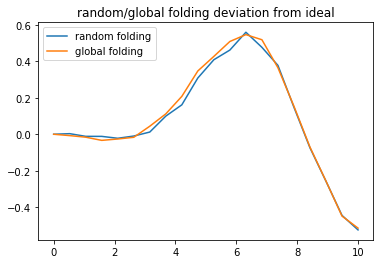

In [70]:
t=np.linspace(0,TT,NN)

fig,ax = plt.subplots()
# ax.plot(t, ideal_averaged_list)
ax.plot(t, deviation1, label = 'random folding')
ax.plot(t, deviation2, label = 'global folding')
ax.set_title("random/global folding deviation from ideal")
ax.legend()